In [136]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import brentq

### Ripple billiard: 

The horizontal scale $x \in [-\pi,\pi]$ and $x = \pm \pi$ give right and left walls.  
The top wall is at $y(x) = d + a \cos x$. The bottom wall is at $y=0$. 


Ripple billiard uses the fact that bottom is horizontal to make an area preserving map
from $(x,p_x)$ or $(x, \sin \alpha)$ where $\alpha$ is angle between trajectory and bottom wall normal. 
This gives a surface of section for the map that is simpler than using circumference and angle from normal. 


Ordinarily the 2 form is $\omega = dx \wedge dp_x + dy\wedge dp_y$.   But
on the bottom wall $y=0$ so trajectories that return to the bottom wall have $\omega = dx \wedge dp_x$. 


Suppose we have impact point $x_0$ and $\sin\alpha$.
The slope of the trajectory is $\tan \alpha$.
To get the slope  $\tan \alpha = \tan ( {\rm arcsin}(sa)) $ .

Leaving $x_0$ the trajectory would be 

$y = x_0 +   (x - x_0) \tan\alpha $





In [252]:
# create a set of points on the ripple billiard rink boundary so it can be plotted
# parameters for the rink are d,a
def lin_rink(d,a):
    xlin = np.linspace(-np.pi,np.pi,200) # top wall 
    ylin = d + a*np.cos(xlin)  # top wall
    
    xlin = np.append(xlin,np.pi) # right wall 
    ylin = np.append(ylin,0)
    
    xlin = np.append(xlin,-np.pi) # bottom wall 
    ylin = np.append(ylin,0)
    
    xlin = np.append(xlin,-np.pi)  # left wall 
    ylin = np.append(ylin,ylin[0])  
    return xlin,ylin

# return a mod b but in range [-b/2, b/2]
def mod_mid(a,b):
    z = (a + b/2)%b - b/2
    return z
    

In [517]:
twopi=2*np.pi

# find bounces in a ripple billiard 
# parms d,a set the rink shape 
# x,y are positions of last bounce 
# phi is angle of trajectory after last bounce, nhat = cos(phi),sin(phi) (x,y) = (x0,y0) + nhat*t is trajectory
# returns x,y,phi,err of next bounce 
#  error is 
#    0 if regular trajectory
#    1 if x,y,phi is a fixed point
#    2 if there is an error in routine 
# uses root finding to find bounces off the top wall
def single_bounce(x,y,phi,d,a):
    
    err_fixed = 1  # error to return if the point is a fixed point 
    if (phi ==np.pi/2): # vertical trajectory going up 
        if (np.abs(x) == np.pi): #on left or right wall, vertical slope
            return x,y,phi,err_fixed  # fixed point 
        else: # go up 
            xnew = x
            ynew = d + a*np.cos(x)
            phinew = -np.pi/2  # reverse direction 
            return xnew,ynew,phinew,0
    if (phi == -np.pi/2):  # vertical trajectory going down
        if (np.abs(x) == np.pi): #on left or right wall, vertical slope
            return x,y,phi,err_fixed  # fixed point 
        else: # go down
            xnew = x
            ynew = 0.
            phinew = np.pi/2
            return xnew,ynew,phinew,0
        
    if (phi==0) and (y==0):  # on bottom wall and horizontal slope so is a fixed point 
        return x,y,phi,err_fixed  
    
    # stops at corners 
    if ((y==0) and (np.abs(x)==np.pi)):    # check for lower corners, fixed point 
        return x,y,phi,err_fixed   
    if ((y==d-a) and (np.abs(x)==np.pi)):  # check for upper corners, fixed point 
        return x,y,phi,err_fixed  
    
    # need to add a check for phi = local slope on top wall ?
     
    slope = np.tan(phi)  # compute slope from phi
    
    # y' = y + slope*(x' - x) line going through current position at this slope 
    if (x > -np.pi): # consider hitting left wall
        xnew = -np.pi
        ynew = y + slope*(xnew-x)  #left wall intersection
        phinew = -phi
        # on left wall phi should be between -pi/2 and pi/2
        phinew = mod_mid(phinew,np.pi)
        if ((ynew >=0) and (ynew <= d-a)):
            return xnew,ynew,phinew,0
        
    if (x < np.pi): # consider hitting right wall     
        xnew = np.pi 
        ynew = y + slope*(xnew-x)  #right wall intersection
        phinew = -phi
        # on right wall phi should be between pi/2 and pi or -pi and -pi/2
        phinew = mod_mid(phinew,2*np.pi) 
        if ((ynew >=0) and (ynew <= d-a)):
            return xnew,ynew,phinew,0
        
    if (y > 0): # consider hitting bottom  wall   
        ynew = 0.0
        xnew =  x - y/slope # bottom intersection 
        phinew = (np.pi - phi )%np.pi  # phi should be in [0,pi]
        if (np.abs(xnew) < np.pi):
            return xnew,ynew,phinew,0
            
    printstuff=0  # for checking errors 
    
    # lastly consider hitting top wall 
    # y' = y + slope*(x' - x) = d + a*cos(x) is a hit of the top wall
    # bracket [-pi,pi]
    yb = y - slope*x
    fa = rfun(-np.pi,d,a,slope,yb) # root finder only works if fa, fb have different signs
    fb = rfun( np.pi,d,a,slope,yb)
    #if (printstuff==1):
    #    print('[-pi,pi]',fa,fb)
    if (np.sign(fa*fb) == -1):   # top intersection via root finding 
        xnewt = brentq(rfun, -np.pi, np.pi,args=(d,a,slope,yb)) # find root with root finder brentq 
        ynewt = d + a*np.cos(xnewt)
        local_slope = -a*np.sin(xnewt) # slope on top 
        phi_local = np.arctan(local_slope)
        phinewt = np.pi- phi + 2*phi_local # is ok?
        phinewt = phinewt%np.pi - np.pi  # should be in [-pi,0]
        return xnewt,ynewt,phinewt,0
    #above case should have covered all points not  on top wall
    
    # if already on top then you need to bracket x+epsilon,pi and -pi,x-epsilon
    #bracket [x,pi]
    epsilon = 1e-8
    #if (x<0):
    if (1==1):
        xpp = x+epsilon
        fa = rfun(xpp,d,a,slope,yb) # root finder only works if fa, fb have different signs
        fb = rfun(np.pi,d,a,slope,yb)
        if (printstuff==1):
            print('[x,pi]',fa,fb)
        if (np.sign(fa*fb) == -1):   # top intersection via root finding 
            xnewt = brentq(rfun, xpp, np.pi,args=(d,a,slope,yb)) # find root with root finder brentq 
            ynewt = d + a*np.cos(xnewt)
            local_slope = -a*np.sin(xnewt) # slope on top 
            phi_local = np.arctan(local_slope)
            phinewt = np.pi- phi + 2*phi_local # is ok?
            phinewt = phinewt%np.pi - np.pi  # should be in [-pi,0]
            return xnewt,ynewt,phinewt,0
        
    #bracket [-pi,x]
    #if (x>0):
        xpp=x-epsilon # nudge away from current location, not perfect but pretty good  
        fa = rfun(-np.pi,d,a,slope,yb) # root finder only works if fa, fb have different signs
        fb = rfun( xpp,d,a,slope,yb)
        if (printstuff==1):
            print('[-pi,x]',fa,fb)
        if (np.sign(fa*fb) == -1):   # top intersection via root finding 
            xnewt = brentq(rfun, -np.pi,xpp,args=(d,a,slope,yb)) # find root with root finder brentq 
            ynewt = d + a*np.cos(xnewt)
            local_slope = -a*np.sin(xnewt) # slope on top 
            phi_local = np.arctan(local_slope)
            phinewt = np.pi- phi + 2*phi_local # is ok?
            phinewt = phinewt%np.pi - np.pi  # should be in [-pi,0]
            return xnewt,ynewt,phinewt,0
    
    print('error, x=',x,'; y=',y,'; phi=',phi) # all cases failed to find next bounce 
    return x,y,phi,2  # error reported here!


# function needed to find where trajectory line crosses top wall, used by root finder
def rfun(x,d,a,slope,yb) :
    return yb + slope*x - d - a*np.cos(x)   
  
    

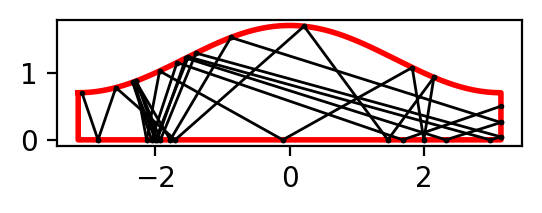

In [498]:
# for testing the single bounce routine!
d = 1.2; a = 0.5; 

fig,ax = plt.subplots(1,1,figsize=(3,2),dpi=200)
ax.set_aspect('equal')
xlin,ylin = lin_rink(d,a)
ax.plot(xlin,ylin,'r-',lw=2)

xold = np.pi; yold=0.5; phiold = 0.33
for i in range(30):
    xnew,ynew,phinew,err = single_bounce(xold,yold,phiold,d,a)
    ax.plot([xold,xnew],[yold,ynew],'ko-',ms=1,lw=1)
    xold = xnew; yold= ynew; phiold=phinew
    if (err>0):
        break
        
    

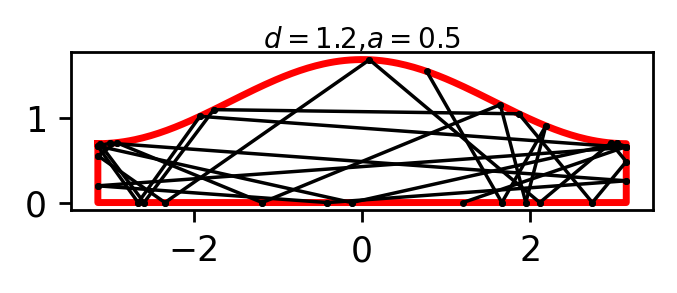

In [598]:
# for testing the single bounce routine!
d = 1.2; a = 0.5; 

fig,ax = plt.subplots(1,1,figsize=(3,2),dpi=250)
ax.set_aspect('equal')
xlin,ylin = lin_rink(d,a)
ax.plot(xlin,ylin,'r-',lw=2)

xold = 1.2; yold=0.0; phiold = 0.33
for i in range(30):
    xnew,ynew,phinew,err = single_bounce(xold,yold,phiold,d,a)
    ax.plot([xold,xnew],[yold,ynew],'ko-',ms=1,lw=1)
    xold = xnew; yold= ynew; phiold=phinew
    if (err>0):
        break

ax.text(0.0,1.84,r'$d=${:.1f},$a=${:.1f}'.format(d,a),fontsize=8,ha='center')
plt.savefig('ripple.png',dpi=200)

In [499]:
# for making a surface of section for ripple billiard 
# here x is position for a point with y=0 
# sa is sin(alpha) where alpha is angle of trajectory from vertical 
# return the next point that reaches the y=0 wall 
# d,a are parameters setting rink geometry
# breaks and returns current point if the single bounce routine gives an error
def surf_sec1(x,sa,d,a):
    y=0.0
    err=0
    alpha =  np.arcsin(sa) # 
    phi = alpha + np.pi/2 
    xold = x; yold=y; phiold = phi; ynew = 1; 
    while (ynew !=0):
        xnew,ynew,phinew,err = single_bounce(xold,yold,phiold,d,a)
        xold = xnew; yold = ynew; phiold=phinew
        if (err>0):
            break

    alphanew = phinew-np.pi/2  # new things are defined if there is a break 
    sanew = np.sin(alphanew)
    return xnew, sanew
    


# get n orbit points that can be plotted for a surface of section 
# run surf_sec1 routine n times for an orbit
# returns:
#   xarr: array of x positions
#   sarr: array of sin(alpha) positions 
def surf_secn(x,sa,d,a,n):
    xarr = [x]
    sarr = [sa]
    for k in range(n):
        xnew, sanew =  surf_sec1(x,sa,d,a)
        x = xnew; sa = sanew
        xarr = np.append(xarr,x)
        sarr = np.append(sarr,sa)
    return xarr, sarr


In [523]:

colorlist = ['blue','black','green','cyan','blueviolet','orange','brown','magenta','red','teal','gold',\
             'springgreen']
nc = len(colorlist)

def plt_stf(ax,x,sa,d,a,n):
    xarr, sarr = surf_secn(x,sa,d,a,n)
    i = np.random.randint(0, high=nc)
    ax.scatter(xarr,sarr,s=0.4,edgecolor='none',facecolor=colorlist[i],lw=1)


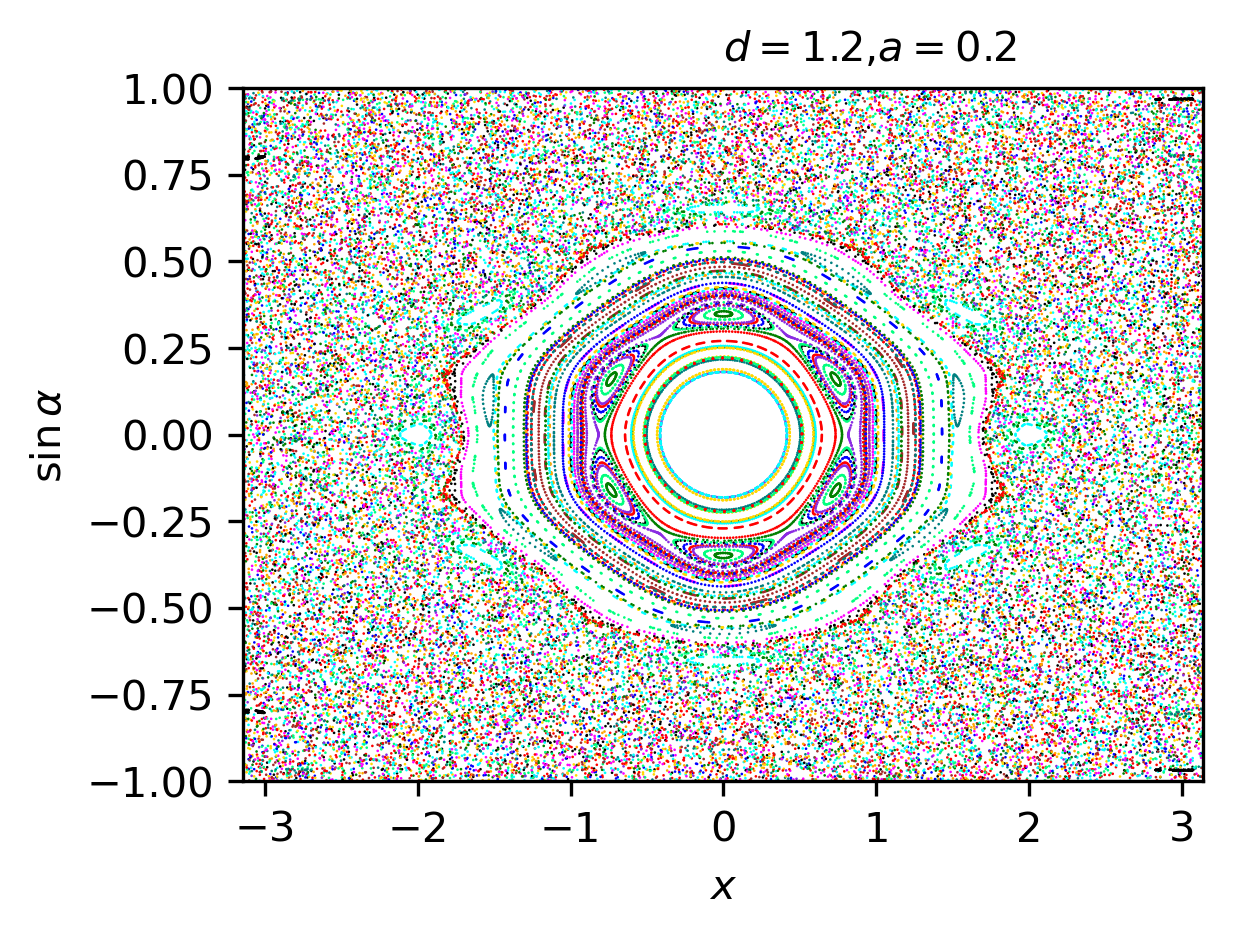

In [524]:
d = 1.2; a = 0.2;n=300

fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=300)
plt.subplots_adjust(left=0.18,top=0.93,bottom=0.16,right=0.98)
#ax.set_aspect('equal')
ax.set_xlim([-np.pi,np.pi])
ax.set_ylim([-1,1])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\sin\alpha$')
ax.text(0.0,1.08,r'$d=${:.1f},$a=${:.1f}'.format(d,a))

for i in range(200):
    sa=np.random.uniform(low=0,high=1); 
    x = np.random.uniform(low=0,high=np.pi)
    plt_stf(ax,x,sa,d,a,n)

plt.savefig('ripple1.png',dpi=300)

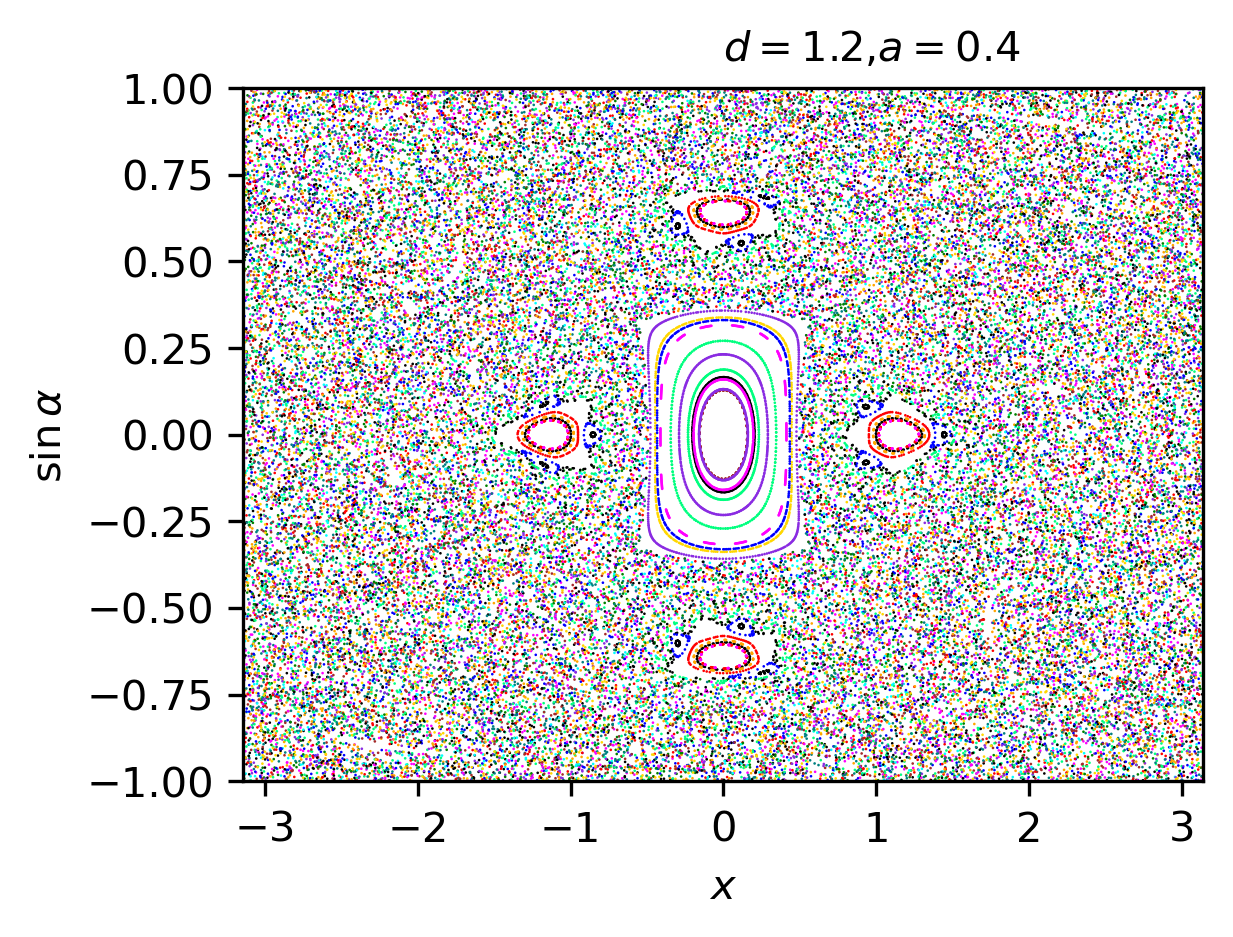

In [526]:
d = 1.2; a = 0.4; n=300

fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=300)
plt.subplots_adjust(left=0.18,top=0.93,bottom=0.16,right=0.98)
ax.set_xlim([-np.pi,np.pi])
ax.set_ylim([-1,1])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\sin\alpha$')
ax.text(0.0,1.08,r'$d=${:.1f},$a=${:.1f}'.format(d,a))

for i in range(200):
    sa=np.random.uniform(low=0,high=1); 
    x = np.random.uniform(low=0,high=np.pi)
    plt_stf(ax,x,sa,d,a,n)

plt.savefig('ripple2.png',dpi=300)

In [ ]:
# I still have some issues with near horizontal trajectories

D-billiard 

radius $R=1$ assumed, $w\in [1,2]$. 

Horizontal width is $wR$. 

$w = 1 + \cos(\theta_{max})$

$\theta_{max}= {\rm arccos}(w-1)  $ 

Could make a surface of section with trajectories going through a horizontal line.
Or maybe p_theta, theta?


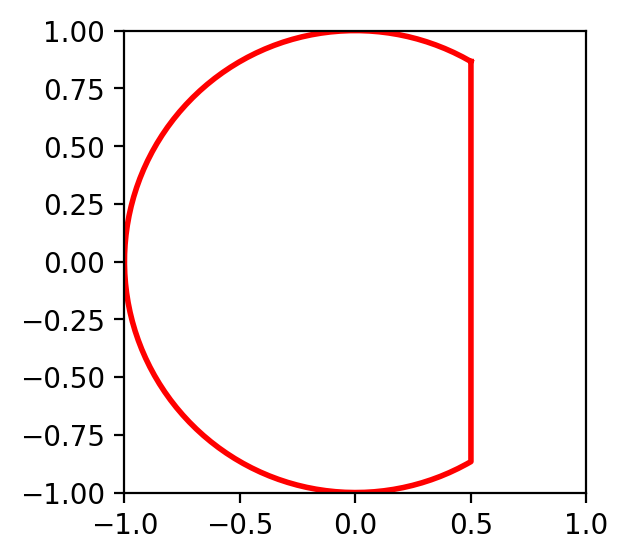

In [603]:
# create a set of points on the D billiard rink so it can be plotted
def lin_rink_D(w):
    theta_max = np.arccos(w-1) # arccos in [0,pi]
    tlin = np.linspace(theta_max,2*np.pi-theta_max,200)
    xlin = np.cos(tlin)
    ylin = np.sin(tlin)
    xlin = np.append(xlin,xlin[0])
    ylin = np.append(ylin,ylin[0])
    
    return xlin,ylin


# return a mod b but in range [-b/2, b/2]
def mod_mid(a,b):
    z = (a + b/2)%b - b/2
    return z

twopi = 2*np.pi
    

fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
ax.set_aspect('equal')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

# show the rink!
w = 1.5; xlin,ylin = lin_rink_D(w); ax.plot(xlin,ylin,'r-',lw=2)

given position $y_0, x_0$ and slope $s$ defining a line 
$y = y_0 + s(x-x_0)$

Find where this line intersects the unit circle. 
Solve for $x$ using quadratic equation 

\begin{align}
y^2 &= y_0^2 + s^2(x-x_0)^2 + 2 y_0 (x-x_0) s \\
& = y_0^2 + s^2 x_0^2 - 2 y_0 x_0s - 2 x_0 s^2 x + 2 y_0 s x  + s^2 x^2 \\
 & = c' + b' x  + a' x^2 
\end{align}
with 
\begin{align}
c' & = y_0^2 + s^2 x_0^2 - 2 s y_0 x_0 \\
b' & = -2 x_0 s^2 + 2 y_0 s\\
a' & = s^2 
\end{align}

\begin{align}
1 - x^2 & = c' + b' x  + a' x^2 \\
0& = (c'-1) + b' x + (a'+1) x^2 \\
& = c + bx+ ax^2 
\end{align}
with 
\begin{align}
c & = y_0^2 + s^2 x_0^2 - 2 s y_0 x_0 - 1\\
b & =  -2 x_0 s^2 + 2 y_0 s\\
a & = s^2 +1
\end{align}

In [741]:
# given position x0,y0 and slope s defining a line y = y_0 + s(x-x0)
# find leftmost x position where it intersects the unit circle 
def give_x_circ(x0,y0,s):
    a = s**2 + 1.0
    b = -2*x0*s**2 + 2*y0*s
    c = y0**2 + s**2*x0**2 - 2*s*y0*x0 - 1.0
    ppos = b**2 - 4*a*c
    if (ppos > 0):
        xp = (-b + np.sqrt(ppos))/(2*a)  # solve quadratic equation 
        xm = (-b - np.sqrt(ppos))/(2*a)
        return xm
    else:
        print('no real root')
        return -10  # error return! here !!!!
    

In [870]:
# if z=0 then point is on circle
#   theta is angle on circle, with 0 to right, in [-pi,pi] 
#   phi is slope w.r.t to normal, in [-pi/2,pi/2]
# if z=1 then point is on segment, 
#   theta is y value, 
#   phi is slope of trajectory w.r.t to horizontal, in [0,pi]
# return new point theta,phi,z,err
# err is 0 if new point moves, 1 if fixed point,  2 if routine fails !!!error!
# w sets geometry of D billiard w in [1,2]
def single_bounce_D(theta_y,phi,z,w):
    if ((w<1) or (w>2)):
        return theta_y,phi,z,2  # error
    xmax = w-1.0
    theta_max = np.arccos(xmax) # in [0,pi]
    err_fixed = 1
    if (z==0): # we are on the circle and phi is angle w.r.t to direction to center of circle in [-pi/2,pi/2]
        if (np.abs(phi) == np.pi/2):
            return theta_y,phi,z,err_fixed   # is a fixed point 
        
        # on circle 
        newtheta = mod_mid(theta_y + np.pi - 2*phi,twopi) # rotate and keep within [-pi,pi]
        if (np.abs(newtheta)<theta_max): # we need to put the next point on the segment!!
            x = np.cos(theta_y)
            y = np.sin(theta_y)
            newphi = phi-theta_y 
            slope = np.tan(-newphi) #  slope w.r.t to vertical line
            newphi = newphi%np.pi  # in [0,pi]
            #print('phi,theta,slope=',phi,theta_y,slope)
            yp = y + slope*(xmax - x)
            newz = 1  # on segment 
            #print('yp',yp)
            return yp,newphi,newz,0  # returns on segment
        else:
            return newtheta,phi,z,0  # stays on circle
        
    else:  # is currently on the segment, phi is angle from horizontal and gives slope  
        # for line that starts from segment, we need to find
        #   where this line intersects the circle 
        if (np.abs(phi)==np.pi/2):
            return theta_y,phi,z,err_fixed  # is a fixed point, because is vertical trajectory on segment 
        
        yp = theta_y # point on segment
        slope = np.tan(phi) # slope directly from angle phi 
        xm = give_x_circ(xmax,yp,slope)  # returns negative most x value for intercept of line with circle
        if (xm < -1):
            err=2  # no real root problem!!!!!
            return theta,phi,z,err  # return an error flag!
        
        ym = yp + slope*(xm-xmax)  # corresponding y value
        newtheta = np.arctan2(ym,xm)  # in [-pi,pi]
        newphi = mod_mid(phi - newtheta,np.pi)  # in [-pi/2,pi/2]
        #print(newphi)
        newz = 0 # on circle 
        return newtheta,newphi,newz,0  # returns on circle
            
#  return (x,y) for plotting points 
def givexy(theta_y,phi,z,w):
    xmax = w-1.0
    if (z==0): # on circle then theta_y is an angle 
        x = np.cos(theta_y)
        y = np.sin(theta_y)
        return x,y
    else: # on segment  now theta_y is y value 
        y = theta_y
        return xmax,y
    
# same as givexy() but for arrays
# returns arrays of x,y positions 
def givexy_arr(theta_yarr,phi_arr,zarr,w):
    xmax = w-1.0
    xarr = phi_arr*0; yarr = phi_arr*0
    ii = (zarr==0)  # on circle 
    xarr[ii] =  np.cos(theta_yarr[ii])
    yarr[ii] =  np.sin(theta_yarr[ii])
    ii = (zarr!=0)  # on segment
    xarr[ii] =  xmax
    yarr[ii] = theta_yarr[ii]
    return xarr,yarr 
    
def give_n_bounces_D(theta_y,phi,z,w,n):
    theta_yarr = []
    phiarr = []
    zarr = []
    theta_yold = theta_y
    phi_old = phi
    z_old = z
    xarr = []
    yarr = []
    for i in range(n):
        theta_yarr = np.append(theta_yarr,theta_yold)
        phiarr = np.append(phiarr,phi_old)
        zarr = np.append(zarr,z_old)
        x,y = givexy(theta_yold,phi_old,z_old,w)
        xarr = np.append(xarr,x)
        yarr = np.append(yarr,y)
        newtheta,newphi,newz,err = single_bounce_D(theta_yold,phi_old,z_old,w)
        if (err==1):
            print('fixed point')
            break   # fixed point and that's it. 
        if (err==2):
            print('no real root problem')
            break
        #print(theta_yold,phi_old,z_old)
        theta_yold = newtheta; phi_old = newphi; z_old = newz
        
    #print(theta_yold,phi_old,z_old)
    return theta_yarr,phiarr,zarr,xarr, yarr 
        

1.4474833324893495 0.4462359458507579 0


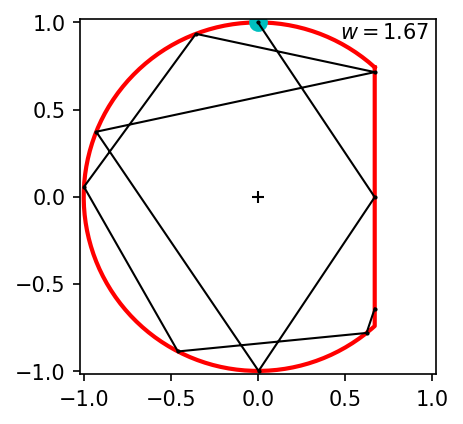

In [860]:
# for testing nbounces routine

fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=150)
ax.set_aspect('equal')
ax.set_xlim([-1.02,1.02])
ax.set_ylim([-1.02,1.02])
plt.subplots_adjust(left=0.18,right=0.97,bottom=0.16,top=0.98)
ax.plot(0,0,'k+')

w = 1.67; xlin,ylin = lin_rink_D(w); ax.plot(xlin,ylin,'r-',lw=2)
axarr[0].plot(0,0,'k+')
ax.text(0.47,0.91,r'$w=${:.2f}'.format(w))

if (1==0):
    theta = 0; phi = 3*np.pi/16; z = 0; n=5  # on circle
    theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(theta,phi,z,w,n)
    ax.plot([xarr[0]],[yarr[0]],'co',ms=8)  # initial condition 
    ax.plot(xarr,yarr,'ko-',ms=1,lw=1)
    
if (1==1):
    theta = np.pi/2; phi = -3*np.pi/16; z = 0; n=10  # on circle
    theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(theta,phi,z,w,n)
    ax.plot([xarr[0]],[yarr[0]],'co',ms=8)  # initial condition 
    ax.plot(xarr,yarr,'ko-',ms=1,lw=1)

if (1==0):
    yb=-0.9; phi =0.0; z = 1; n=3  # on segment
    theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(yb,phi,z,w,n)
    ax.plot([xarr[0]],[yarr[0]],'co',ms=8)  # initial condition 
    ax.plot(xarr,yarr,'go-',ms=1,lw=1)

# another example of a screw up below!

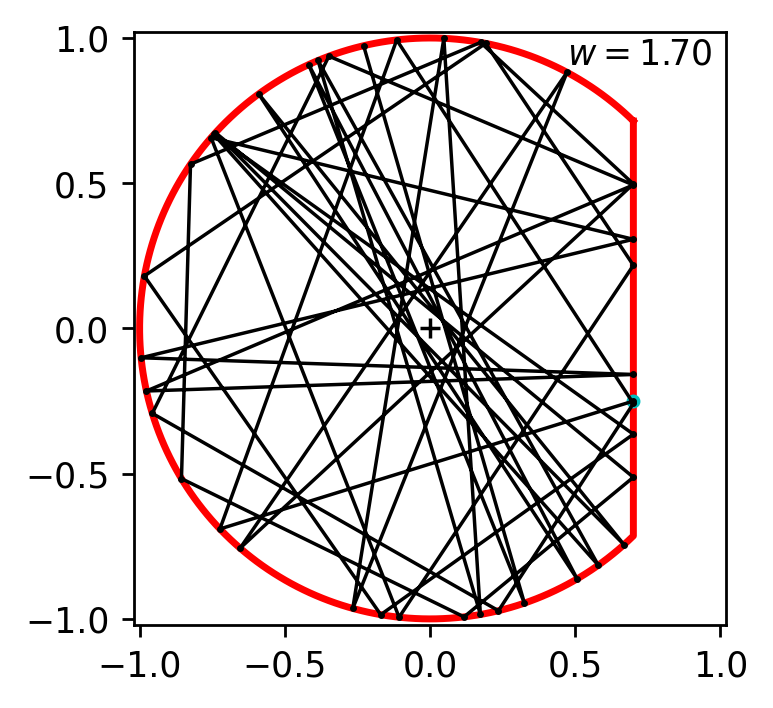

In [882]:
# for testing routines

fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=250)
ax.set_aspect('equal')
ax.set_xlim([-1.02,1.02])
ax.set_ylim([-1.02,1.02])
plt.subplots_adjust(left=0.18,right=0.97,bottom=0.16,top=0.98)

w = 1.7; xlin,ylin = lin_rink_D(w); ax.plot(xlin,ylin,'r-',lw=2)
ax.plot(0,0,'k+')

theta = -0.25; phi = 0.3; z = 1; n=40
theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(theta,phi,z,w,n)
ax.plot([xarr[0]],[yarr[0]],'co',ms=3)  # initial condition 
ax.plot(xarr,yarr,'ko-',ms=1,lw=1)
    
ax.text(0.47,0.91,r'$w=${:.2f}'.format(w))
plt.savefig('Dbill.png')

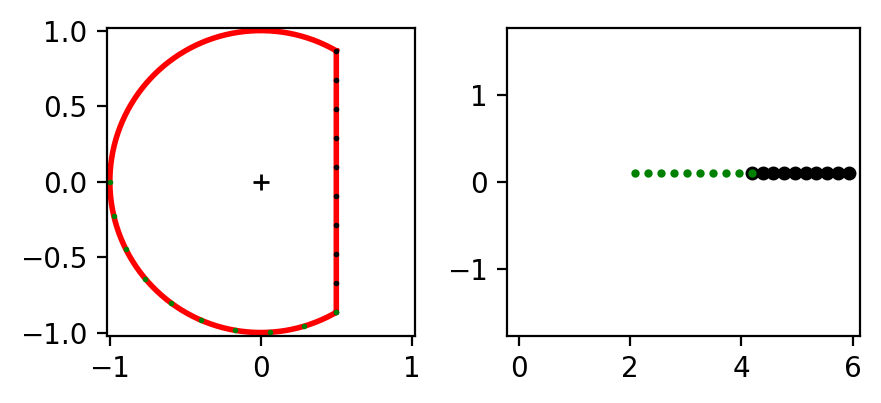

In [863]:
# we would like to have sarr be array of positions along boundary 
# and barr a trajectory from normal angle 
# sarr which is position should lie in [0,twopi-2*theta_max+ 2*ymax]
# barr which is angle should like in [-pi/2,pi/2]
def coord_trans_D(theta_yarr,phiarr,zarr,w):
    xmax = w-1.0
    theta_max = np.arccos(xmax)
    ymax = np.sin(theta_max)
    sarr = np.zeros(len(phiarr))  # to store position along boundary 
    barr = np.zeros(len(phiarr))
    ii = (zarr==0)  # points on circle
    #print(ii)
    # theta goes from -theta_max to -pi and pi to theta_max 
    # theta%twopi goes from theta_max to 2pi-theta_max
    sarr[ii] = theta_yarr[ii]%twopi - theta_max  # should go from 0 to twopi-2*theta_max
    #print(theta_yarr[ii]%twopi,xmax,theta_max)
    barr[ii] = mod_mid(phiarr[ii],np.pi) # within [-pi/2,pi/2]
    
    ii = (zarr!=0)  # points on segment   
    barr[ii] = mod_mid(phiarr[ii],np.pi)  # phi was in [0,pi] but here we take angle in [-pi/2,pi/2]
    sarr[ii] = theta_yarr[ii] + twopi-2*theta_max + ymax  
    # should go from twopi-2*theta_max to twopi-2*theta_max + 2*ymax  
    return sarr,barr 
    

# test coord_trans_D
fig,axarr = plt.subplots(1,2,figsize=(5,2),dpi=200)
axarr[0].set_aspect('equal')
axarr[0].set_xlim([-1.02,1.02])
axarr[0].set_ylim([-1.02,1.02])
eps = 0.2
axarr[1].set_xlim([0-eps,smax+eps])
axarr[1].set_ylim([-np.pi/2 - eps,np.pi/2+eps])

w = 1.5; xlin,ylin = lin_rink_D(w); axarr[0].plot(xlin,ylin,'r-',lw=2)
axarr[0].plot(0,0,'k+')

xmax = w-1.0
theta_max = np.arccos(xmax)
ymax = np.sin(theta_max)
smax = twopi - 2*theta_max + 2*ymax
#print(theta_max,ymax)

#theta_lin = np.linspace(-np.pi,-theta_max,10)
#theta_lin = np.linspace(theta_max,np.pi,10)
theta_lin = np.linspace(-ymax,ymax,10)
#print(theta_lin)
phi_arr = theta_lin*0  + 0.1   # if take tan of this is actual slope , so pi/2 is up
# phi is is in [0,pi]
zarr = theta_lin*0  + 1  # on segment 
xarr,yarr =  givexy_arr(theta_lin,phi_arr,zarr,w)
axarr[0].plot(xarr,yarr,'ko',lw=1,ms=1)
sarr,barr = coord_trans_D(theta_lin,phi_arr,zarr,w)
axarr[1].plot(sarr,barr,'ko',ms=4)


theta_lin = np.linspace(-np.pi,-theta_max,10) # on circle
#theta_lin = np.linspace(theta_max,np.pi,10)
phi_arr = theta_lin*0  + 0.1 
zarr = theta_lin*0  
xarr,yarr =  givexy_arr(theta_lin,phi_arr,zarr,w)
axarr[0].plot(xarr,yarr,'go',lw=1,ms=1)
sarr,barr = coord_trans_D(theta_lin,phi_arr,zarr,w)
axarr[1].plot(sarr,barr,'go',ms=2)



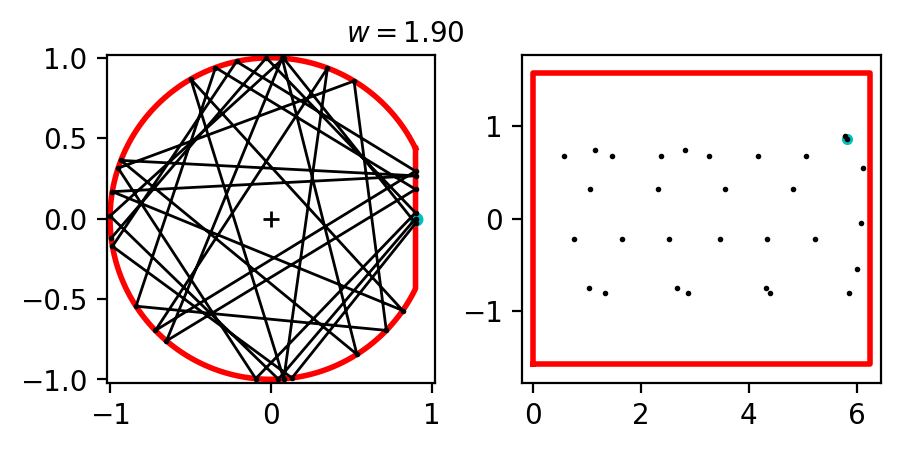

In [904]:
# for testing nbounces,coord_trans_B routine

w = 1.9

fig,axarr = plt.subplots(1,2,figsize=(5,2),dpi=200)
plt.subplots_adjust(left=0.18,right=0.97,bottom=0.16,top=0.98)
axarr[0].set_aspect('equal')
axarr[0].set_xlim([-1.02,1.02])
axarr[0].set_ylim([-1.02,1.02])
xmax = w-1.0
theta_max = np.arccos(xmax)
ymax = np.sin(theta_max)
smax = twopi - 2*theta_max + 2*ymax
eps = 0.2
axarr[1].set_xlim([0-eps,smax+eps])
axarr[1].set_ylim([-np.pi/2 - eps,np.pi/2+eps])
axarr[0].text(0.47,1.10,r'$w=${:.2f}'.format(w))

# show rink on left
xlin,ylin = lin_rink_D(w); axarr[0].plot(xlin,ylin,'r-',lw=2)
axarr[0].plot(0,0,'k+')
# show boundary on right too
sqa_x = [0,smax,smax,0,0]
sqa_y = [-np.pi/2,-np.pi/2,np.pi/2,np.pi/2,-np.pi/2]
axarr[1].plot(sqa_x,sqa_y,'r-',lw=2)

if (1==1):
    yb = 0.0; phi = 0.864 ; z = 1; n=30  # choose initial condition on segment 
    theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(yb,phi,z,w,n)
    sarr,barr = coord_trans_D(theta_arr,phiarr,zarr,w)
    
if (1==0):
    theta = np.pi/3+0.1; phi = np.pi/6 ; z = 0; n=30  # choose initial condition on circle
    theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(theta,phi,z,w,n)
    sarr,barr = coord_trans_D(theta_arr,phiarr,zarr,w)


axarr[0].plot([xarr[0]],[yarr[0]],'co',ms=4)  # initial condition 
axarr[0].plot(xarr,yarr,'ko-',ms=1,lw=1)
axarr[1].plot(sarr[0],barr[0],'co',ms=3) # initial condition
axarr[1].plot(sarr,barr,'ko',ms=1)




In [705]:
colorlist = ['blue','black','green','cyan','blueviolet','orange','brown','magenta','red','teal','gold',\
             'springgreen']
nc = len(colorlist)

#def plt_stf_D(ax,x,sa,d,a,n):
#    xarr, sarr = surf_secn(x,sa,d,a,n)
#    i = np.random.randint(0, high=nc)
#    ax.scatter(xarr,sarr,s=0.4,edgecolor='none',facecolor=colorlist[i],lw=1)


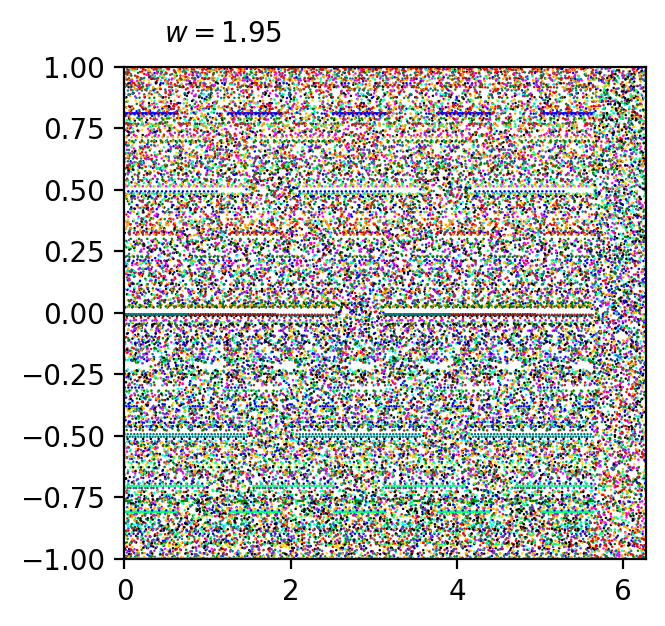

In [880]:
# for testing nbounces,coord_trans_B routine

w = 1.95 # choose shape

#set up figure 
fig,ax = plt.subplots(1,1,figsize=(3.3,3),dpi=200)
plt.subplots_adjust(left=0.18,right=0.97,bottom=0.16,top=0.98)
xmax = w-1.0
theta_max = np.arccos(xmax)
ymax = np.sin(theta_max)
smax = twopi - 2*theta_max + 2*ymax
eps = 0.0
ax.set_xlim([0-eps,smax+eps])
#ax.set_ylim([-np.pi/2 - eps,np.pi/2+eps])
ax.set_ylim([-1,1])
#ax.text(0.47,1.70,r'$w=${:.2f}'.format(w))
ax.text(0.47,1.10,r'$w=${:.2f}'.format(w))

sqa_x = [0,smax,smax,0,0]
#sqa_y = [-np.pi/2,-np.pi/2,np.pi/2,np.pi/2,-np.pi/2]
sqa_y = [-1,-1,1,1,-1]
#ax.plot(sqa_x,sqa_y,'r-',lw=2)

z = 0; n=400
# points on the circle 
for k in range(50):
    theta = np.random.uniform(low=theta_max,high=np.pi); 
    phi = np.random.uniform(low=-np.pi/2,high=np.pi/2); 
    theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(theta,phi,z,w,n)
    sarr,barr = coord_trans_D(theta_arr,phiarr,zarr,w)
    i = np.random.randint(0, high=nc)
    #axarr[0].plot(xarr,yarr,'-',color=colorlist[i],lw=1,alpha=0.1)
    ax.scatter(sarr,np.sin(barr),s=0.8,edgecolor='none',facecolor=colorlist[i],lw=1)

z = 1;  #points on segment 
for k in range(50):
    yb = np.random.uniform(low=-ymax,high=ymax); 
    phi = np.random.uniform(low=0,high=np.pi); 
    theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(yb,phi,z,w,n)
    sarr,barr = coord_trans_D(theta_arr,phiarr,zarr,w)
    i = np.random.randint(0, high=nc)
    #axarr[0].scatter(xarr,yarr,s=0.8,edgecolor='none',facecolor=colorlist[i],lw=1)
    ax.scatter(sarr,np.sin(barr),s=0.8,edgecolor='none',facecolor=colorlist[i],lw=1)
   

Seems area preserving! but not very pretty at all

 maybe we need to do a surface of section instead?

Horizontal lines are periodic orbits that would exist in the absense of the segment.
For example you can have a bunch of triangles as long as no vertex extends onto the segment. 
you can slightly tilt the trangle and it is a happy periodic orbit. 


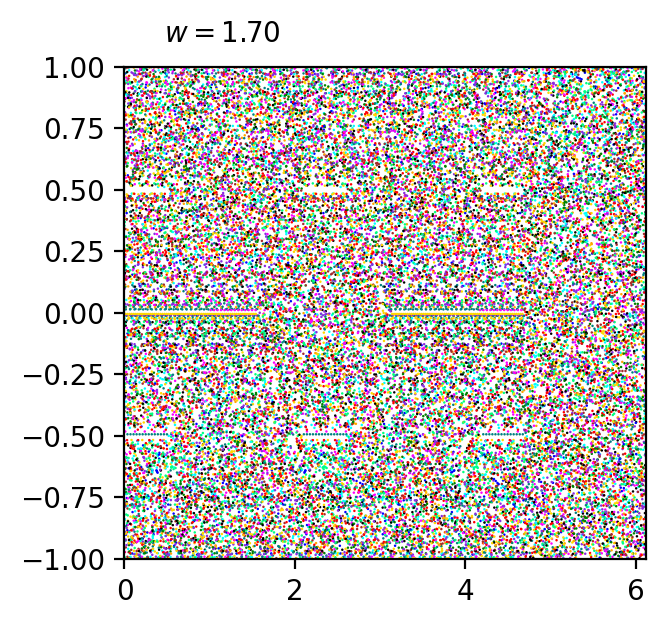

In [878]:
# for testing nbounces,coord_trans_B routine

w = 1.7 # choose shape

#set up figure 
fig,ax = plt.subplots(1,1,figsize=(3.3,3),dpi=200)
plt.subplots_adjust(left=0.18,right=0.97,bottom=0.16,top=0.98)
xmax = w-1.0
theta_max = np.arccos(xmax)
ymax = np.sin(theta_max)
smax = twopi - 2*theta_max + 2*ymax
eps = 0.0
ax.set_xlim([0-eps,smax+eps])
#ax.set_ylim([-np.pi/2 - eps,np.pi/2+eps])
ax.set_ylim([-1,1])
#ax.text(0.47,1.70,r'$w=${:.2f}'.format(w))
ax.text(0.47,1.10,r'$w=${:.2f}'.format(w))

sqa_x = [0,smax,smax,0,0]
#sqa_y = [-np.pi/2,-np.pi/2,np.pi/2,np.pi/2,-np.pi/2]
sqa_y = [-1,-1,1,1,-1]
#ax.plot(sqa_x,sqa_y,'r-',lw=2)

z = 0; n=400
# points on the circle 
for k in range(50):
    theta = np.random.uniform(low=theta_max,high=np.pi); 
    phi = np.random.uniform(low=-np.pi/2,high=np.pi/2); 
    theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(theta,phi,z,w,n)
    sarr,barr = coord_trans_D(theta_arr,phiarr,zarr,w)
    i = np.random.randint(0, high=nc)
    #axarr[0].plot(xarr,yarr,'-',color=colorlist[i],lw=1,alpha=0.1)
    ax.scatter(sarr,np.sin(barr),s=0.8,edgecolor='none',facecolor=colorlist[i],lw=1)

z = 1;  #points on segment 
for k in range(50):
    yb = np.random.uniform(low=-ymax,high=ymax); 
    phi = np.random.uniform(low=0,high=np.pi); 
    theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(yb,phi,z,w,n)
    sarr,barr = coord_trans_D(theta_arr,phiarr,zarr,w)
    i = np.random.randint(0, high=nc)
    #axarr[0].scatter(xarr,yarr,s=0.8,edgecolor='none',facecolor=colorlist[i],lw=1)
    ax.scatter(sarr,np.sin(barr),s=0.8,edgecolor='none',facecolor=colorlist[i],lw=1)
   

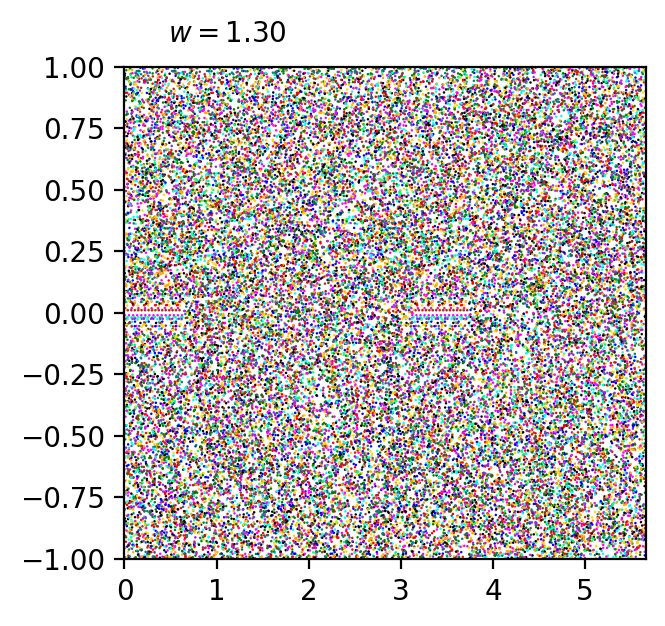

In [881]:
# for testing nbounces,coord_trans_B routine

w = 1.3 # choose shape

#set up figure 
fig,ax = plt.subplots(1,1,figsize=(3.3,3),dpi=200)
plt.subplots_adjust(left=0.18,right=0.97,bottom=0.16,top=0.98)
xmax = w-1.0
theta_max = np.arccos(xmax)
ymax = np.sin(theta_max)
smax = twopi - 2*theta_max + 2*ymax
eps = 0.0
ax.set_xlim([0-eps,smax+eps])
#ax.set_ylim([-np.pi/2 - eps,np.pi/2+eps])
ax.set_ylim([-1,1])
#ax.text(0.47,1.70,r'$w=${:.2f}'.format(w))
ax.text(0.47,1.10,r'$w=${:.2f}'.format(w))

sqa_x = [0,smax,smax,0,0]
#sqa_y = [-np.pi/2,-np.pi/2,np.pi/2,np.pi/2,-np.pi/2]
sqa_y = [-1,-1,1,1,-1]
#ax.plot(sqa_x,sqa_y,'r-',lw=2)

z = 0; n=400
# points on the circle 
for k in range(50):
    theta = np.random.uniform(low=theta_max,high=np.pi); 
    phi = np.random.uniform(low=-np.pi/2,high=np.pi/2); 
    theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(theta,phi,z,w,n)
    sarr,barr = coord_trans_D(theta_arr,phiarr,zarr,w)
    i = np.random.randint(0, high=nc)
    #axarr[0].plot(xarr,yarr,'-',color=colorlist[i],lw=1,alpha=0.1)
    ax.scatter(sarr,np.sin(barr),s=0.8,edgecolor='none',facecolor=colorlist[i],lw=1)

z = 1;  #points on segment 
for k in range(50):
    yb = np.random.uniform(low=-ymax,high=ymax); 
    phi = np.random.uniform(low=0,high=np.pi); 
    theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(yb,phi,z,w,n)
    sarr,barr = coord_trans_D(theta_arr,phiarr,zarr,w)
    i = np.random.randint(0, high=nc)
    #axarr[0].scatter(xarr,yarr,s=0.8,edgecolor='none',facecolor=colorlist[i],lw=1)
    ax.scatter(sarr,np.sin(barr),s=0.8,edgecolor='none',facecolor=colorlist[i],lw=1)
   

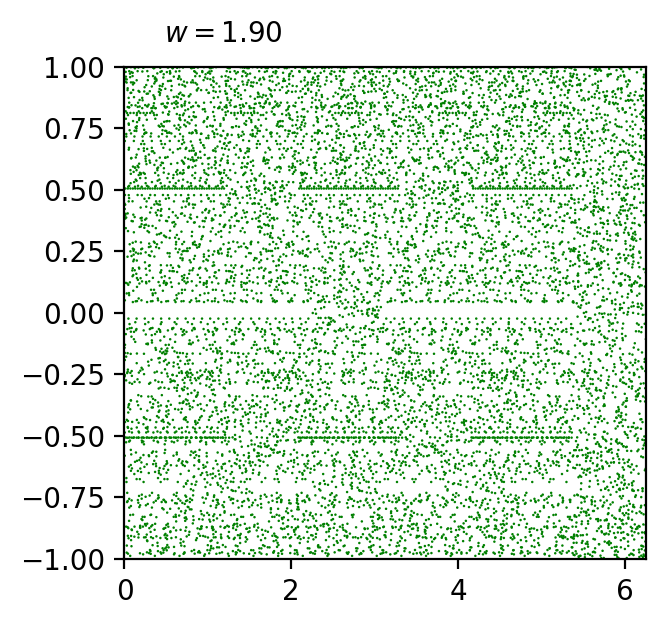

In [910]:
# for testing nbounces,coord_trans_B routine

w = 1.9 # choose shape

#set up figure 
fig,ax = plt.subplots(1,1,figsize=(3.3,3),dpi=200)
plt.subplots_adjust(left=0.18,right=0.97,bottom=0.16,top=0.98)
xmax = w-1.0
theta_max = np.arccos(xmax)
ymax = np.sin(theta_max)
smax = twopi - 2*theta_max + 2*ymax
eps = 0.0
ax.set_xlim([0-eps,smax+eps])
#ax.set_ylim([-np.pi/2 - eps,np.pi/2+eps])
ax.set_ylim([-1,1])
#ax.text(0.47,1.70,r'$w=${:.2f}'.format(w))
ax.text(0.47,1.10,r'$w=${:.2f}'.format(w))

sqa_x = [0,smax,smax,0,0]
#sqa_y = [-np.pi/2,-np.pi/2,np.pi/2,np.pi/2,-np.pi/2]
sqa_y = [-1,-1,1,1,-1]
#ax.plot(sqa_x,sqa_y,'r-',lw=2)

z = 0; n=10000
# points on the circle 
for k in range(0):
    theta = np.random.uniform(low=theta_max,high=np.pi); 
    phi = np.random.uniform(low=-np.pi/2,high=np.pi/2); 
    theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(theta,phi,z,w,n)
    sarr,barr = coord_trans_D(theta_arr,phiarr,zarr,w)
    i = np.random.randint(0, high=nc)
    #axarr[0].plot(xarr,yarr,'-',color=colorlist[i],lw=1,alpha=0.1)
    ax.scatter(sarr,np.sin(barr),s=0.8,edgecolor='none',facecolor=colorlist[i],lw=1)

z = 1;  #points on segment 
for k in range(1):
    yb = np.random.uniform(low=-ymax,high=ymax); 
    phi = np.random.uniform(low=0,high=np.pi); 
    theta_arr,phiarr,zarr,xarr,yarr = give_n_bounces_D(yb,phi,z,w,n)
    sarr,barr = coord_trans_D(theta_arr,phiarr,zarr,w)
    i = np.random.randint(0, high=nc)
    #axarr[0].scatter(xarr,yarr,s=0.8,edgecolor='none',facecolor=colorlist[i],lw=1)
    ax.scatter(sarr,np.sin(barr),s=0.8,edgecolor='none',facecolor=colorlist[i],lw=1)
   